<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.SmokerStatusPrediction/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [3]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/11.SmokerStatusPrediction/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download data

In [7]:
df_source = pd.read_csv(manager.train_path, index_col=0)
df_source.shape

(159256, 23)

# Outliers in the source data

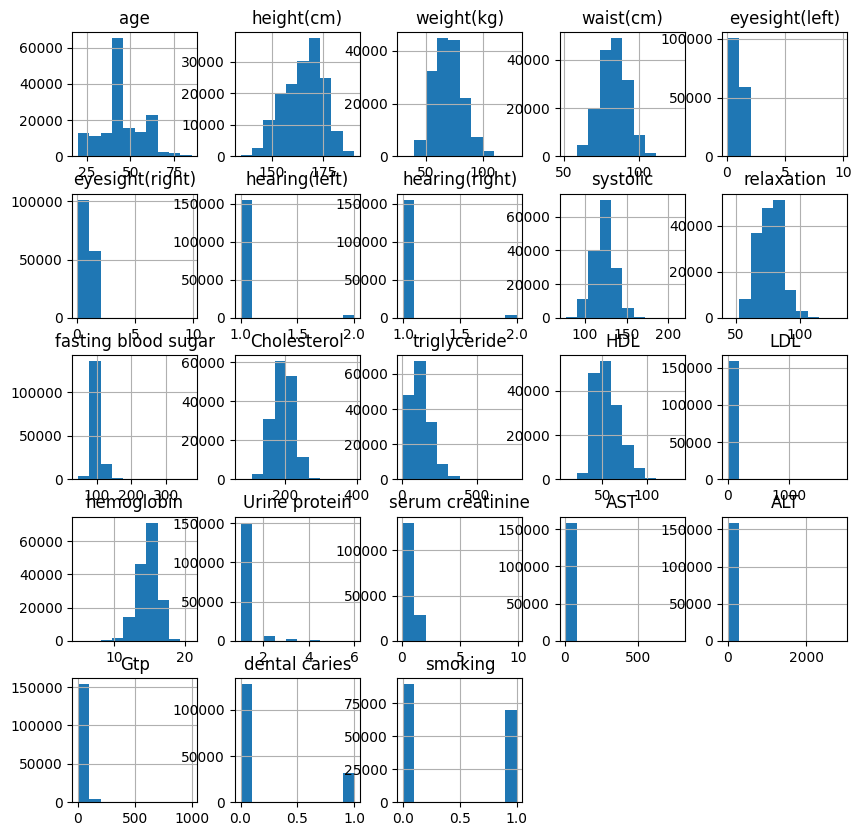

In [9]:
_ = df_source.hist(figsize=(10, 10))

## Left, right eyesight outliers

In [38]:
QUANTILE = 0.995


left_eyesight_subset = df_source.loc[
    df_source['eyesight(left)'] > df_source['eyesight(left)'].quantile(QUANTILE),
    ['eyesight(left)', 'smoking']
]

right_eyesight_subset = df_source.loc[
    df_source['eyesight(right)'] > df_source['eyesight(right)'].quantile(QUANTILE),
    ['eyesight(right)', 'smoking']
].head()

In [39]:
left_eyesight_subset.shape[0] / df_source.shape[0], \
right_eyesight_subset.shape[0] / df_source.shape[0]

(0.0044707891696388205, 3.139599135982318e-05)

In [40]:
left_eyesight_subset.head()

,eyesight(left),smoking
id,,
20,2.0,1
413,9.9,0
460,2.0,1
741,9.9,0
1117,9.9,0


In [41]:
right_eyesight_subset.head()

,eyesight(right),smoking
id,,
105,2.0,0
213,9.9,0
235,2.0,1
444,9.9,0
662,2.0,1


In [42]:
left_eyesight_subset['smoking'].value_counts()

1    383
0    329
Name: smoking, dtype: int64

In [43]:
right_eyesight_subset['smoking'].value_counts()

0    3
1    2
Name: smoking, dtype: int64

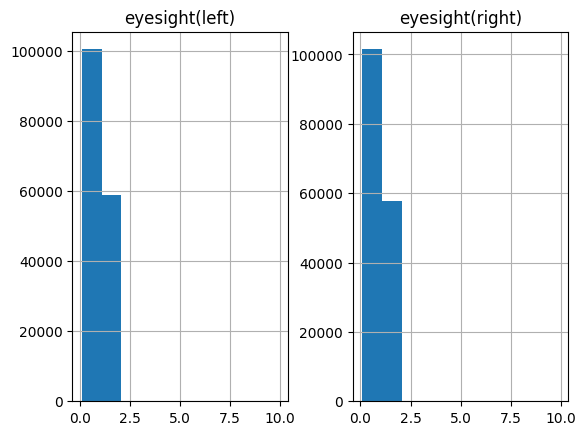

In [46]:
_ = df_source[['eyesight(left)', 'eyesight(right)']].hist()

In [47]:
df_source = df_source.loc[
    df_source['eyesight(left)'] < df_source['eyesight(left)'].quantile(QUANTILE),
    :
]

In [49]:
df_source = df_source.loc[
    df_source['eyesight(right)'] < df_source['eyesight(right)'].quantile(QUANTILE),
    :
]

In [50]:
df_source.shape

(128344, 23)

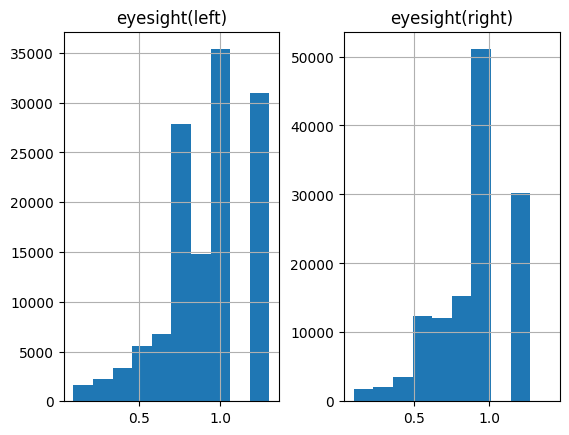

In [52]:
_ = df_source[['eyesight(left)', 'eyesight(right)']].hist()

## Fasting blood sugar

array([[<Axes: title={'center': 'fasting blood sugar'}>]], dtype=object)

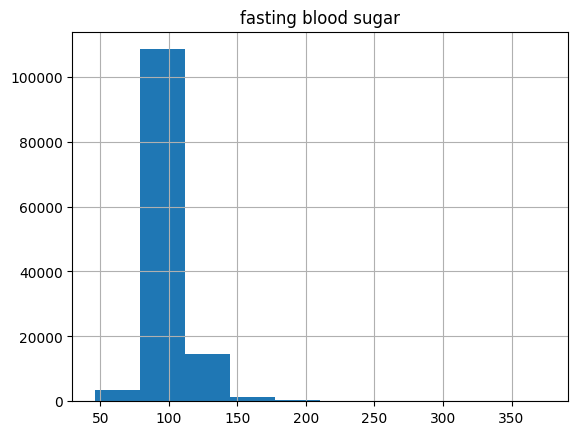

In [53]:
feature='fasting blood sugar'
df_source[[feature]].hist()

In [56]:
df_source[feature].max(), df_source[feature].quantile(0.995)

(375, 181.0)

In [57]:
df_source[feature] = df_source[feature].clip(
    upper = df_source[feature].quantile(0.995)
)

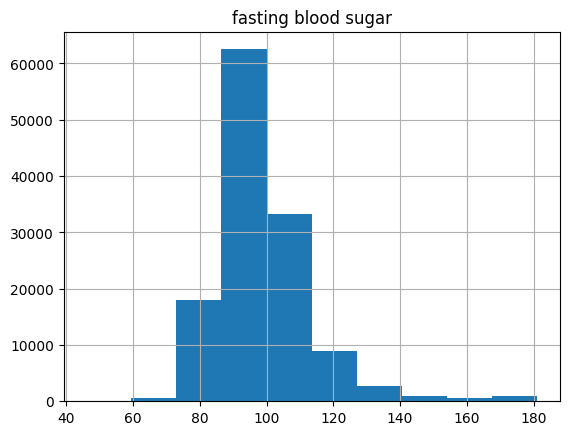

In [58]:
_ = df_source[[feature]].hist()

## LDL

<Axes: >

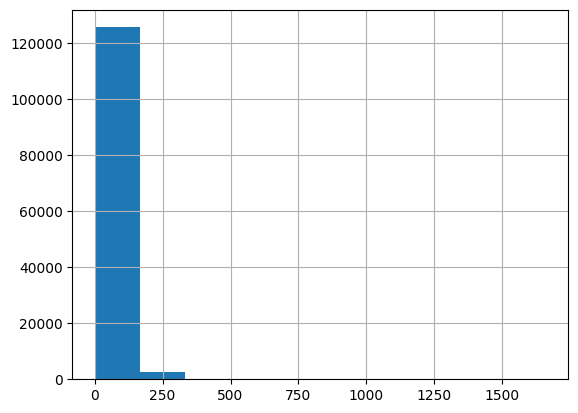

In [62]:
feature='LDL'
_ = df_source[feature].hist()

<Axes: >

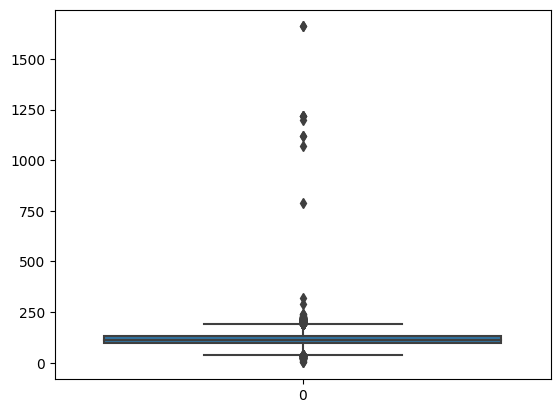

In [63]:
sns.boxplot(
    df_source[feature]
)

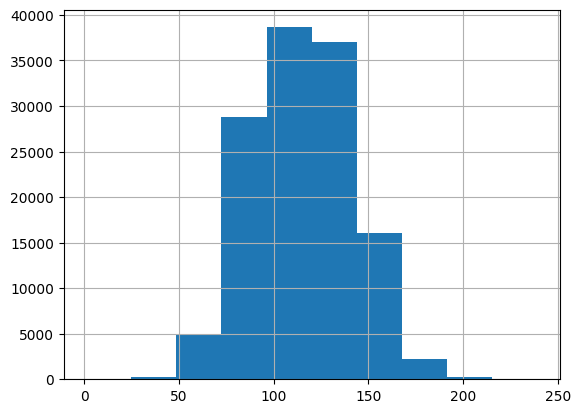

In [66]:
df_source[feature] = df_source[feature].clip(upper=df_source[feature].quantile(0.9999))
_ = df_source[feature].hist()

## Serum creatinine

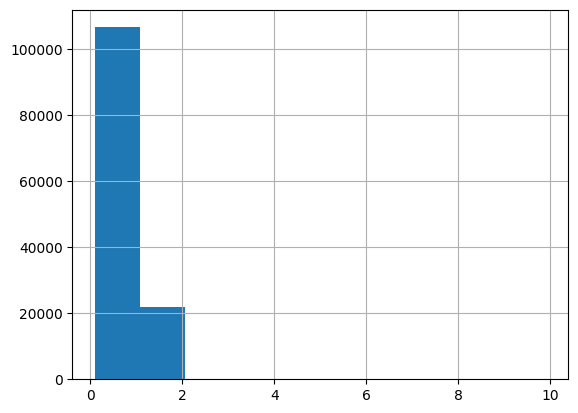

In [67]:
feature = 'serum creatinine'
_ = df_source[feature].hist()

In [68]:
df_source[feature] = df_source[feature].clip(upper=df_source[feature].quantile(0.9999))

<Axes: >

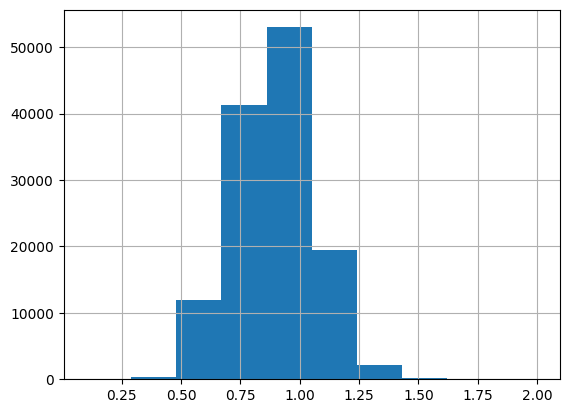

In [69]:
_ = df_source[feature].hist()

## AST, ALT, Gtp

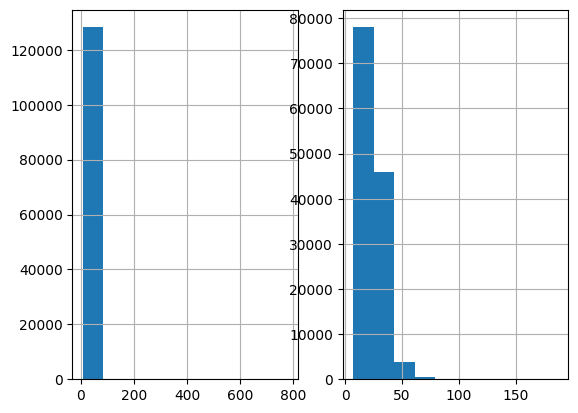

In [70]:
def clip_data(df, feature, quantile):
    _, ax = plt.subplots(1, 2)
    df[feature].hist(ax=ax[0])
    df[feature] = df[feature].clip(upper=df[feature].quantile(quantile))
    df[feature].hist(ax=ax[1])

    return df

In [ ]:
df_source = clip_data(df_source, 'AST', 0.9999)

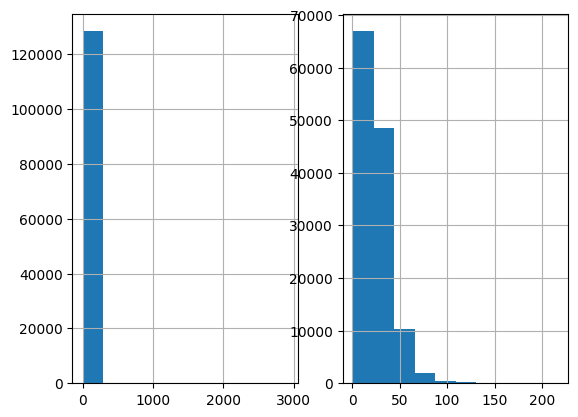

In [71]:
df_source = clip_data(df_source, 'ALT', 0.9999)

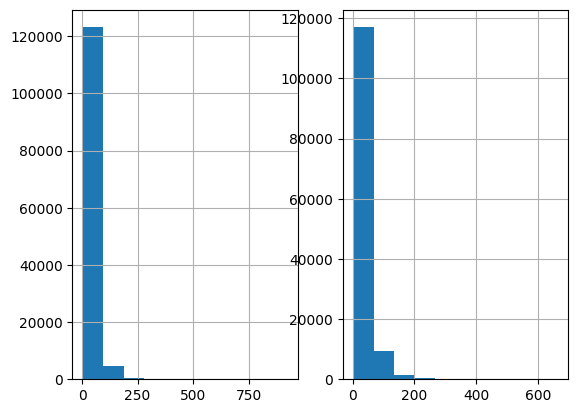

In [72]:
df_source = clip_data(df_source, 'Gtp', 0.9999)

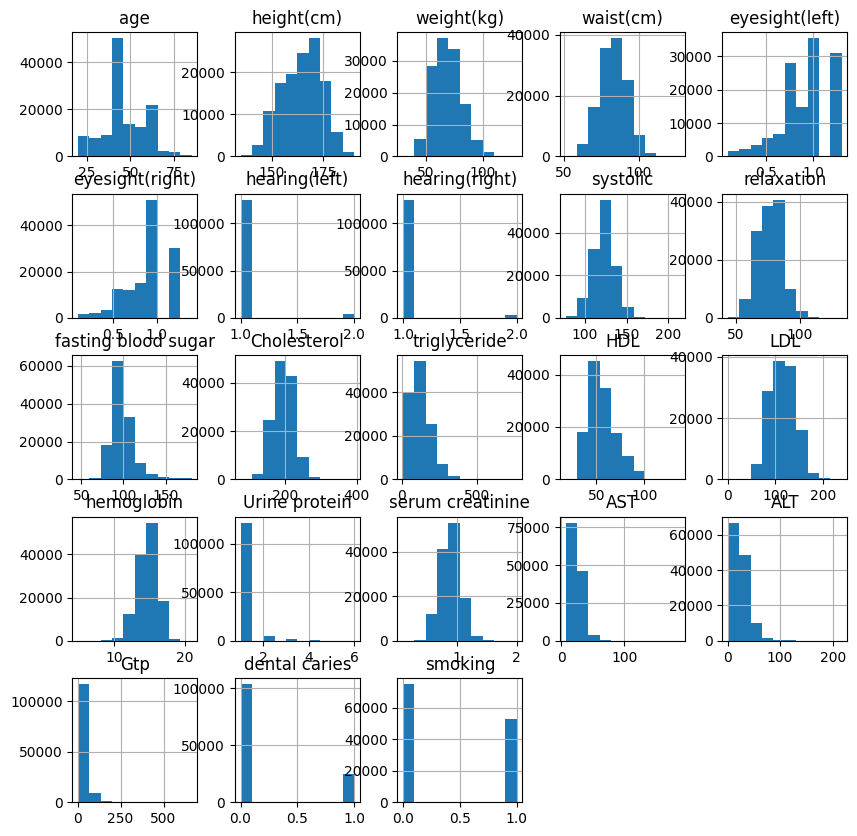

In [74]:
_ = df_source.hist(figsize=(10, 10))

# Train / val / test split

In [76]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8
RANDOM_STATE = 42

df_train, df_val = train_test_split(
    df_source,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_source['smoking']
)

# Data exploration (on train set)

## Overweight index

In [77]:
df_train.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

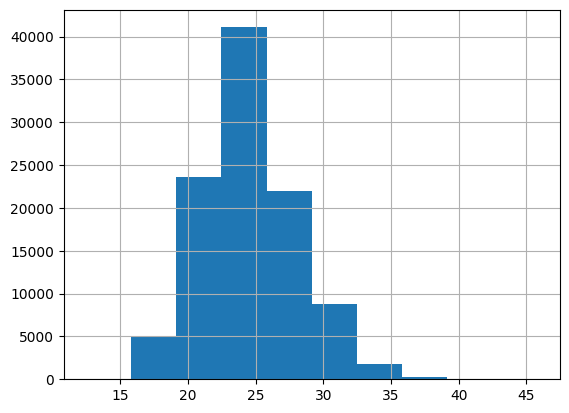

In [78]:
df_train['BMI'] = df_train['weight(kg)'] / ((df_train['height(cm)'] / 100) ** 2)
_ = df_train['BMI'].hist()

In [79]:
df_train['is_overweight'] = df_train['BMI'] > 25

In [82]:
df_train.groupby('is_overweight')['smoking'].value_counts()

is_overweight  smoking
False          0          39932
               1          22695
True           0          20187
               1          19861
Name: smoking, dtype: int64

## Systolic

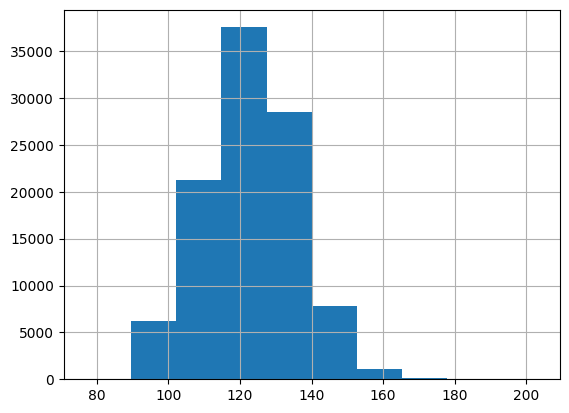

In [83]:
_ = df_train['systolic'].hist()

In [86]:
df_train['high_systolic'] = df_train['systolic'] > 140

In [88]:
df_train.groupby(['high_systolic', 'smoking'])[['high_systolic', 'smoking']].value_counts()

high_systolic  smoking
False          0          55236
               1          40011
True           0           4883
               1           2545
dtype: int64

<Axes: >

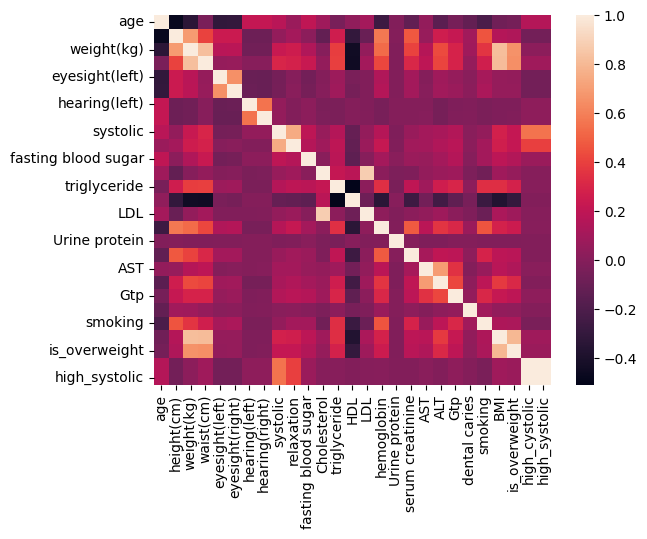

In [91]:
sns.heatmap(df_train.corr())